# Step-by-Step Testing of Snowbot Production Code

In [225]:
import os 
import sys
import pandas as pd

## packages needed for snowbot:

	import pandas as pd
	import urllib
	from datetime import datetime, date, timedelta
	import boto3 - installed
	import os 
	import io
	import re
    
    from pykrige.ok3d import OrdinaryKriging3D - installed
	from pykrige.uk3d import UniversalKriging3D - installed

	from pykrige.rk import Krige - installed
	from pykrige.compat import GridSearchCV - installed
	from numpy import typecodes
	import numpy
	import pandas as pd
    
    
    import pandas as pd
	import numpy as np
	import zipfile - included in standard library
	import pickle - included in standard library
	from sklearn.metrics import mean_squared_error
	import matplotlib.pyplot as plt
    
    import tweepy - installed

In [6]:
os.getcwd()

'/nfshome/cb4102/ARGO/production_testing'

## Package Check

In [368]:
import snowbot as sb #works

## Fetch Data Check

In [4]:
sb.fetchData() #error updating to s3, but writes csvs locally

/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


ClientError: An error occurred (AccessDenied) when calling the ListObjects operation: Access Denied

## Kriging Script Testing

In [9]:
sb.krigingscript() #not working

## Production-Model Testing

Each function used in the production run is taken out of the production code and tested individually below, changes are incorporated back into the production model

In [231]:
	import pandas as pd
	import numpy as np
	import zipfile
	import pickle
	from datetime import datetime, date, timedelta
	from sklearn.metrics import mean_squared_error
	import matplotlib.pyplot as plt
	from scipy.stats import pearsonr
	import xgboost as xgb

In [232]:
	def read_swe(url_path):
	    '''function to read in and format the raw swe data (y data)'''
	    swe_vol = pd.read_csv(url_path, header=None, names=['date', 'area', 'vol'])
	    swe_vol['date'] = pd.to_datetime(swe_vol['date'])
	    swe_vol.set_index('date', inplace=True)
	    swe_vol.drop(columns=['area'], axis=1, inplace=True)
	    swe_vol = pd.DataFrame(swe_vol)

	    return swe_vol

In [233]:
	def read_file(file_path):
	    '''Function to read in daily x data'''
	    station = pd.read_csv(file_path)
	    station.dropna(axis=1,how='all',inplace=True)
	    station.replace('---', '0', inplace=True)        
	    station['date'] = pd.to_datetime(station['date'])
	    station = station.sort_values(by='date')
	    station.set_index('date', inplace=True)  # put date in the index
	    station = station[station.index > '1984-09-29']
        # removes days where there is no y-data
	    cols = station.columns
	    station[cols] = station[cols].apply(pd.to_numeric, errors='coerce')
	    station = station.apply(lambda row: row.fillna(row.mean()), axis=1)
	    try:
	        station.drop(columns=['Unnamed: 0'], axis=1, inplace=True)  # drop non-station columns
	    except:
	        pass

	    return station

In [234]:
	def merge_data(df1, df2):
	    """merge station and swe estimate data"""
	    swe = pd.merge(left=df1, right=df2, left_index=True, right_index=True)
	    swe.dropna(axis=1, how='all', inplace=True)

	    x = swe.iloc[:, 1:]
	    y = swe.iloc[:, :1]

	    x_array = x.values

	    return swe, x, y, x_array

In [235]:
	def create_lags(x, n_in=1, n_out=1, dropnan=True):

	    n_vars = 1 if type(x) is list else x.shape[1]
	    df = pd.DataFrame(x)
	    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
	    for i in range(n_in, 0, -1):
	        cols.append(df.shift(i))
	        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
	    for i in range(0, n_out):
	        cols.append(df.shift(-i))
	        if i == 0:
	            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
	        else:
	            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
	    agg = pd.concat(cols, axis=1)
	    agg.columns = names
    # drop rows with NaN values
	    if dropnan:
	        agg.dropna(inplace=True)
 
	    return agg

In [278]:
	def train_test_split(x, y):
	    y.reset_index(inplace=True)
	    y_filter = y.iloc[2:]
	    xy_lag = pd.merge(left=y_filter, right=x, how='left', left_index=True, right_index=True)
	    xy_lag.set_index('date', inplace=True)
        
	    last_data = datetime.date(2018, 8, 29)
	    today = datetime.date.today()
	    predict_range = today - last_data
	    predict_range = round(age.total_seconds() / 86400)

	    # split into three data frames: train, test, and predict
	    train = xy_lag.iloc[:round(len(xy_lag) * 0.65)]
	    test = xy_lag.iloc[round(len(xy_lag) * 0.65):-(predict_range)]
	    predict = xy_lag.iloc[-(predict_range):]  # predict is last 125 rows where there is no Y-data

	    train.dropna(subset=['vol'], inplace=True)
	    test.dropna(subset=['vol'], inplace=True)

	    # split into X and Y for each of train, test, and predict
	    y_train = train['vol']
	    x_train = train.drop(['vol'],axis=1)

	    y_test = test['vol']
	    x_test = test.drop(['vol'],axis=1)

	    y_predict = predict['vol']
	    x_predict = predict.drop(['vol'],axis=1)

	    return y_train, x_train, y_test, x_test, y_predict, x_predict, train, test, predict

In [302]:
	def model(x_train, x_test, x_predict, y_test, y_train):
	    xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree=0.3, 
                                  learning_rate=0.05,max_depth=6, n_estimators=150,seed=13)
	    xg_reg.set_params(min_child_weight=5)
	    xg_reg.set_params(gamma=5)
	    xg_reg.set_params(reg_alpha=0)
	    xg_reg.set_params(reg_lambda=1.5)

	    xg_reg.fit(x_train,y_train)
	    train_preds = xg_reg.predict(x_train)
	    test_preds = xg_reg.predict(x_test)
	    predict_preds = xg_reg.predict(x_predict)
	    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
	    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds
                                               ))
	    return train_preds, test_preds, predict_preds, test_rmse, train_rmse

In [353]:
	def vis1(today, train, train_preds, test, test_preds, predict, predict_preds, y_train, y_test, train_rmse, test_rmse):
	    # join back to dates for graphing

	    train_graph = pd.merge(left=pd.DataFrame(train.index), right=pd.DataFrame(train_preds), how='left',
	                           left_index=True, right_index=True)

	    test_graph = pd.merge(left=pd.DataFrame(test.index), right=pd.DataFrame(test_preds), how='left',
	                          left_index=True, right_index=True)

	    pred_graph = pd.merge(left=pd.DataFrame(predict.index), right=pd.DataFrame(predict_preds), how='left',
	                          left_index=True, right_index=True)

	    train_graph.set_index('date', inplace=True)
	    test_graph.set_index('date', inplace=True)
	    pred_graph.set_index('date', inplace=True)

	    # convert training data to data frames for graphing
	    y_train = pd.DataFrame(y_train)
	    y_test = pd.DataFrame(y_test)

	    # Plot long time series

	    fig = plt.figure(figsize=(20, 10))
	    ax = fig.add_subplot(111)

	    ax.plot(train_graph[0], color='g', linestyle='--', label='Train Pred')
	    ax.plot(y_train['vol'], color='b', alpha=0.5, label='Train Act.')

	    ax.plot(test_graph[0], color='c', linestyle='--', label='Test Pred')
	    ax.plot(y_test['vol'], color='b', alpha=0.5, label='Test Act.')

	    ax.plot(pred_graph[0], color='m', label='Forecast')

	    ax.set_xlabel("Date")
	    ax.set_ylabel("SWE Volume by Day")
	    ax.set_title("Daily SWE Estimates Across the Sierras, 1984-2018, Actual vs. Estimates and Projection")
	    plt.legend()

	    ax.text('1984-1-1', 47, "RMSE of the train set: {}".format(round(train_rmse, 4)))
	    ax.text('1984-1-1', 45, "RMSE of the test set: {}".format(round(test_rmse, 4)))
        
	    ax.set_ylim(0,50)

	    font = {'family' : 'normal',
	        'weight' : 'bold',
	        'size'   : 14}

	    plt.rc('font', **font)

	    plt.savefig('SWE Time Series {}.png'.format(today))

In [359]:
	def vis2(today, train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test):

	    # join back to dates for graphing

	    train_graph = pd.merge(left=pd.DataFrame(train.index), right=pd.DataFrame(train_preds), how='left',
	                           left_index=True, right_index=True)

	    test_graph = pd.merge(left=pd.DataFrame(test.index), right=pd.DataFrame(test_preds), how='left',
	                          left_index=True, right_index=True)

	    pred_graph = pd.merge(left=pd.DataFrame(predict.index), right=pd.DataFrame(predict_preds), how='left',
	                          left_index=True, right_index=True)

	    train_graph.set_index('date', inplace=True)
	    test_graph.set_index('date', inplace=True)
	    pred_graph.set_index('date', inplace=True)

	    # convert training data to data frames for graphing
	    y_train = pd.DataFrame(y_train)
	    y_test = pd.DataFrame(y_test)

	    # scatter plot to show comparison of predicted vs actual on the training and test data sets

	    fig = plt.figure(figsize=(15, 15))
	    ax = fig.add_subplot(122)

	    ax.scatter(y_test['vol'], test_graph[0], color='b')

	    ax1 = fig.add_subplot(121)

	    ax1.scatter(y_train['vol'], train_graph[0], color='g')

	    ax.set_xlabel("Actual")
	    ax.set_ylabel("Predicted")
	    ax.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Test set)")

	    ax1.set_xlabel("Actual")
	    ax1.set_ylabel("Predicted")
	    ax1.set_title("Daily SWE Across the Sierras, 1984-2017, Actual vs. Predicted (Train set)")

	    ax.text(1,37,"Test correlation: {}".format(round(y_test['vol'].corr(test_graph[0]), 2)))
	    ax1.text(1,37,"Train correlation: {}".format(round(y_train['vol'].corr(train_graph[0]), 3)))

	    ax.set_ylim(0,40)
	    ax.set_xlim(0,40)
        
	    ax1.set_ylim(0,40)
	    ax1.set_xlim(0,40)
        
	    font = {'family' : 'normal',
	        'weight' : 'bold',
	        'size'   : 10}

	    plt.rc('font', **font)

	    plt.savefig("SWE Correlation Plots {}.png".format(today))

In [347]:
	def vis3(today, train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test):

	    train_graph = pd.merge(left=pd.DataFrame(train.index), right=pd.DataFrame(train_preds), how='left',
	                           left_index=True, right_index=True)

	    test_graph = pd.merge(left=pd.DataFrame(test.index), right=pd.DataFrame(test_preds), how='left',
	                          left_index=True, right_index=True)

	    pred_graph = pd.merge(left=pd.DataFrame(predict.index), right=pd.DataFrame(predict_preds), how='left',
	                          left_index=True, right_index=True)

	    train_graph.set_index('date', inplace=True)
	    test_graph.set_index('date', inplace=True)
	    pred_graph.set_index('date', inplace=True)

	    # convert training data to data frames for graphing
	    y_train = pd.DataFrame(y_train)
	    y_test = pd.DataFrame(y_test)

	    # prep historical data for graphing

	    total_swe = pd.concat([y_train, y_test])

	    total_swe.reset_index(inplace=True)

	    # extract year and day of year from full date
	    total_swe['year'] = total_swe['date'].dt.year
	    total_swe['doy'] = total_swe['date'].dt.dayofyear

	    # set up select series for graph

	    avg_swe_series = total_swe[total_swe['date'] < '2017-10-01'].groupby('doy')['vol'].mean()
	    select_year_series = total_swe[(total_swe['date'] < '1991-10-01') & (total_swe['date'] > '1990-09-30')]

	    # format data frames

	    avg_swe_series = pd.DataFrame(avg_swe_series)
	    select_year_series = select_year_series[['doy', 'vol']]

	    avg_swe_series.reset_index(inplace=True)

	    # calculate water day from calendar day

	    avg_swe_series['water_day'] = [x - 273 if x >= 273 else x + 92 for x in avg_swe_series['doy']]
	    select_year_series['water_day'] = [x - 273 if x >= 273 else x + 92 for x in select_year_series['doy']]

	    avg_swe_series = avg_swe_series.iloc[:, 1:]
	    select_year_series = select_year_series.iloc[:, 1:]

	    actuals_series = pd.merge(select_year_series, avg_swe_series, how='left', left_on='water_day', right_on='water_day')

	    actuals_series['std_upper'] = actuals_series['vol_y'] + actuals_series['vol_y'].std()
	    actuals_series['std_lower'] = actuals_series['vol_y'] - actuals_series['vol_y'].std()

	    # adjust the prediction data

	    pred_graph.reset_index(inplace=True)

	    pred_series = pred_graph.iloc[33:]  # just takes dates for the beginning of the water year

	    # extract year and day of year from full date
	    pred_series['year'] = pred_series['date'].dt.year
	    pred_series['doy'] = pred_series['date'].dt.dayofyear

	    pred_series['water_day'] = [x - 273 if x >= 273 else x + 92 for x in pred_series['doy']]

	    pred_series = pred_series[['water_day', 0]]

	    #get day level standard deviation
	    total_swe['water_day'] = [x-273 if x >= 273 else x+92 for x in total_swe['doy']]

	    swe_agg = total_swe.groupby('water_day')['vol'].agg(['mean','std'])

	    #get upper and lower standard deviation bounds
	    swe_agg['std_upper'] = swe_agg['mean'] + swe_agg['std']
	    swe_agg['std_lower'] =  swe_agg['mean'] - swe_agg['std']

	    #resent index so I can use water day in the charting
	    swe_agg.reset_index(inplace=True)

	    fig = plt.figure(figsize=(20,10))
	    ax = fig.add_subplot(111)

	    ax.plot(actuals_series['water_day'],actuals_series['vol_x'],color='c',label='1990-91 Water Year',linewidth=3)
	    ax.plot(actuals_series['water_day'],actuals_series['vol_y'],color='b',linestyle='--',alpha=0.5,label='1984-2016 Avg. Water Year',linewidth=3)
	    ax.plot(pred_series['water_day'],pred_series[0],color='g',label='2018-19 Water Year Forecast',linewidth=3)

	    ax.set_xlabel("Day of the Water Year")
	    ax.set_ylabel("Sierra Nevada Total Storage [km3]")
	    ax.set_title("SWE Daily Estimate Comparison")
	    ax.set_ylim(0.15,50)
	    ax.set_xlim(0,365)

	    plt.fill_between(swe_agg['water_day'],swe_agg['std_lower'], swe_agg['std_upper'], facecolor='lightgray',label='1984-2016 +/- 1 std.')


	    plt.legend()

	    ax.text(1,48,"Updated as of: {}".format(today))
	    ax.text(1,46,"Today's Forecast: {} [km3]".format(pred_series[0].iloc[-1:].values))

	    font = {'family':'normal','weight':'bold','size': 16}

	    plt.text(0.05,-5,"Comment: Today's forecast is {}% of the historical average".format((pred_series[0].iloc[-1:].values / actuals_series['vol_y'][len(pred_series) -1]) * 100))
	    plt.rc('font', **font)

	    plt.savefig("Daily Water Year Graph_{}.png".format(today))

## Individual Function Testing

In [262]:
	import pandas as pd
	import numpy as np
	import zipfile
	import pickle
	import datetime
	from sklearn.metrics import mean_squared_error
	import matplotlib.pyplot as plt
	import xgboost as xgb
	from scipy.stats import pearsonr
	import datetime 

### Individual Tests

In [280]:
swe_vol = read_swe(url_path) #works

In [281]:
file = 'data/backup_20190319_03.csv' #use old file for now

In [282]:
station = read_file(file) #works

In [283]:
swe, x, y, x_array = merge_data(swe_vol,station) #works

In [284]:
x_lag = create_lags(x_array,n_in=2,n_out=1) #works

In [286]:
#works
y_train, x_train, y_test, x_test, y_predict, x_predict, train, test, predict = train_test_split(x_lag,y)

/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [303]:
#works
train_preds, test_preds, predict_preds, test_rmse, train_rmse = model(x_train, x_test,
                                                                          x_predict, y_test, y_train)

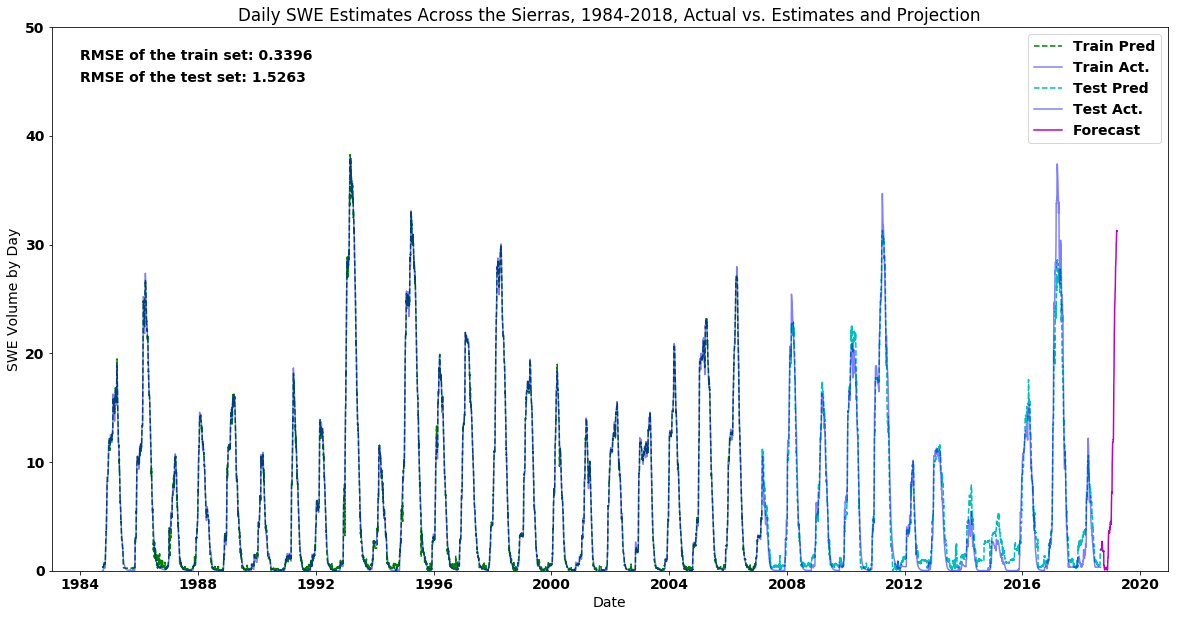

In [354]:
#works
vis1(today, train, train_preds, test, test_preds, predict, predict_preds, y_train, y_test, train_rmse, test_rmse)

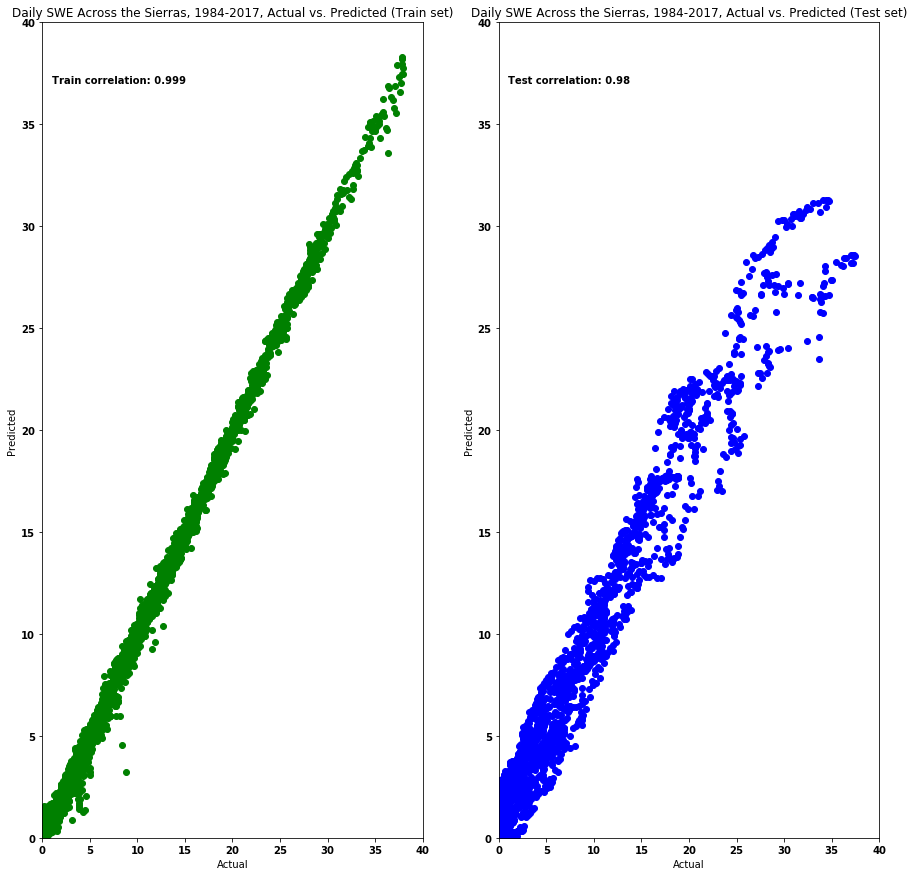

In [360]:
#works
vis2(today, train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test)

/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

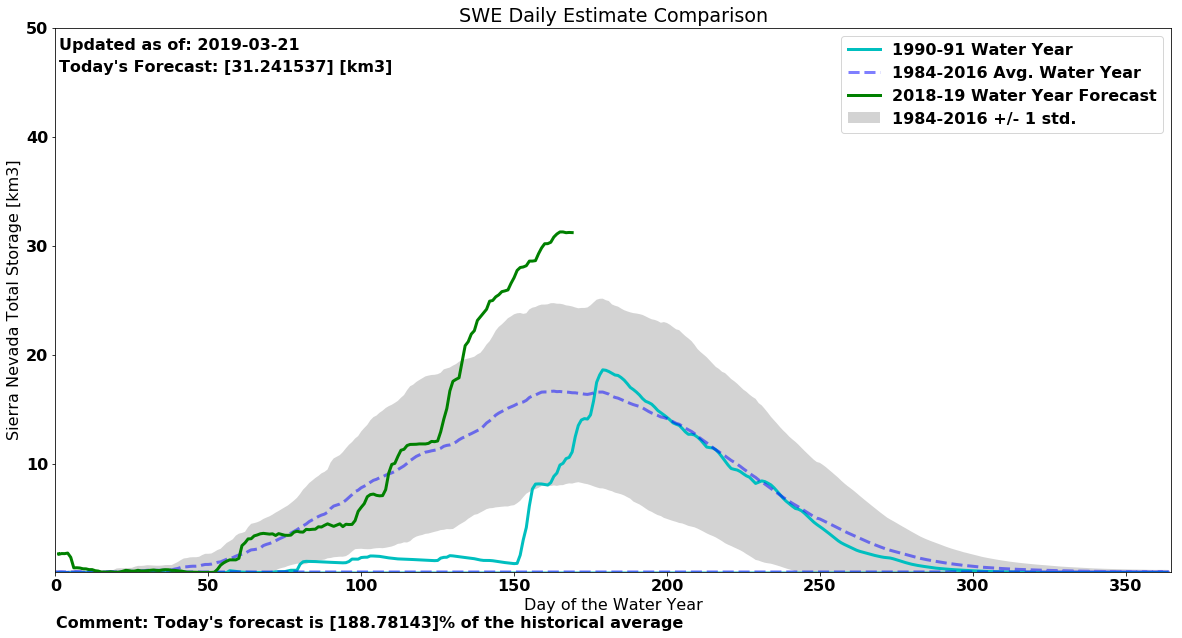

In [348]:
#works
vis3(today,train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test)

### All of Production Tested Together

In [370]:
#works!
	today = str(date.today())
	sens = 3
	fname = "{}_0{}".format(today.replace('-',''),sens)
	#file = "data/backup_{}.csv".format(fname)
	file = 'data/backup_20190319_03.csv' 
	url_path = 'https://s3-us-west-2.amazonaws.com/cawater-public/swe/pred_SWE.txt'

	swe_vol = read_swe(url_path)
	station = read_file(file)
	swe, x, y, x_array = merge_data(swe_vol, station)
	x_lag = create_lags(x_array, n_in=2, n_out=1)
	y_train, x_train, y_test, x_test, y_predict, x_predict, train, test, predict = train_test_split(x_lag, y)
	train_preds, test_preds, predict_preds, test_rmse, train_rmse = model(x_train, x_test,
                                                                          x_predict, y_test, y_train)

	vis1(today, train, train_preds, test, test_preds, predict, predict_preds, y_train, y_test, train_rmse, test_rmse)
	vis2(today, train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test)
	vis3(today, train, test, predict, train_preds, test_preds, predict_preds, y_train, y_test)

/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3179: DtypeWarning: Columns (3,13,56,59,105,108,123,147,163,187,197,200,206,240,256,260,270,274,283,302,323,336,371,391,404,423,435,452,464) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(async_code, result, async_=True)):
/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/cb4102/.conda/envs/airflow/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nfshome/cb410

In [369]:
sb.production_script()

NameError: name 'url_path' is not defined

# Twitter Bot Testing

In [376]:
import tweepy

In [ ]:
user = 'snowbot_SN'
password = 'SecretArchitectureSection'
cons_key = 'GEma54Uj8od5TfgAlvCYRocmh'
cons_secret = 'byWoJX2sUbtOtYyZPBLNRGuOcRQvMGjYJpji6G2fQAqpIkPyXh'
access_token = '968656486204284928-AsEooRchyNIWmht4OQR2bXegRT4yz9Z'
access_secret = '9OohC1VJEcg1XhbQrQ1msGgx1VF5YJiiBDaiT3fJDxBAV'
file_list = 'Daily Water Year Graph_2019-03-21.png'

In [383]:
def twitter_post(cons_key,cons_secret,access_token,at_secret,file_list):
	auth = tweepy.OAuthHandler(cons_key,cons_secret)
	auth.set_access_token(access_token,at_secret)
	api = tweepy.API(auth)

	image = open(file_list, 'rb')
	message = 'This is a test'
	response = api.upload_media(media=image)
	media_id = [response['media_id']]
	api.update_status(status=message, media_ids=media_id)

In [384]:
import tweepy

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

public_tweets = api.home_timeline()
for tweet in public_tweets:
    print tweet.text

In [385]:
twitter_post(cons_key,cons_secret,access_token,access_secret,file_list)

AttributeError: 'API' object has no attribute 'upload_media'

In [ ]:
import tweepy
from time import sleep

folderpath = "/path/to/your/directory/"
def tweepy_creds():
    consumer_key = 'Removed'
    consumer_secret = 'Removed'
    access_token = 'Removed'
    access_token_secret = 'Removed'

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    return tweepy.API(auth)

def getPathsFromDir(dir, EXTS="extensions=,png,jpg,jpeg,gif,tif,tiff,tga,bmp"):
    return this.listPaths(folder, EXTS)

def tweet_photos(api):
    imagePaths = getPathsFromDir(this.dataPath(folderpath))
    for x in imagePaths:
        status = "tweet text here"
        try:
            api.update_with_media(filename=x,status=status)
            print "Tweeted!"
            sleep(900)
        except Exception as e:
            print "encountered error! error deets: %s"%str(e)
            break

if __name__ == "__main__":